## Dimensionality reduction: Hydrogen mechanism (H2_Li)

### Step 1: Zero-dimensional simulation

In [1]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pylab as plt

gas = ct.Solution('/Users/aditya/work/projects/isml/jupyter/mech/H2_Li/H2_Li.cti')

# simulation parameters
nstep = 2000
dtime = 1.e-7

# composition
gas.TPY = 1120.0, ct.one_atm*1.2, 'H2:0.00811,O2:0.18316,H2O:0.05182,N2:0.75692'
r = ct.IdealGasConstPressureReactor(gas)

# data matrix (size NTxNV)
nt = nstep+1
nx = nt
nsc = gas.Y.size
nv = nsc + 1
X = np.zeros((nt,nv)) # data matrix
p = np.zeros((nt))


# simulation object
sim = ct.ReactorNet([r])
time = np.zeros(nt)

# initial condition
for i in range(nsc):
    X[0,i] = gas.Y[i]
X[0,nv-1] = gas.T
p[0] = gas.P


for n in range(nstep):
    time[n+1]=time[n]+dtime
    # integrates the solution in time
    sim.advance(time[n+1])
    # append data to X matrix
    for i in range(nsc):
        X[n+1,i] = gas.Y[i]
    X[n+1,nv-1] = gas.T
    p[n+1] = gas.P
    
    


#### Compute reaction rate

In [2]:
nRR = gas.n_reactions        # number of reactions
RR = np.zeros((nt,nRR))   # reaction rates matrix


# print reactions
# for ir in range(nRR):
#     print(gas.reactions()[ir])

# compute reaction rates at each time step
for it in range(nt):
    gas.TP = X[it,nv-1],p[it]
    gas.Y = X[it,:nsc]
    for ir in range(nRR):
        RR[it,ir] = gas.net_rates_of_progress[ir]



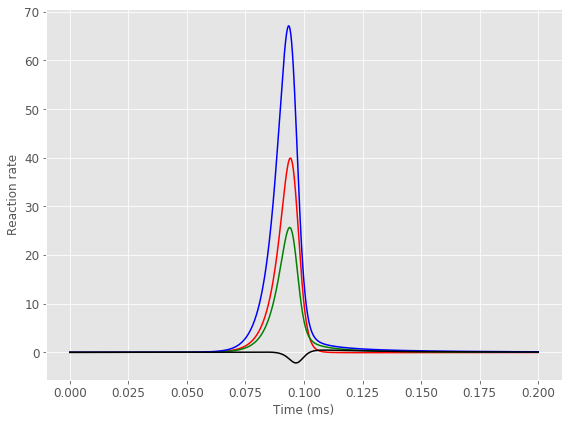

In [3]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 

plt.figure()
plt.plot(time*1e3, RR[:,0], '-r')
plt.plot(time*1e3, RR[:,1], '-g')
plt.plot(time*1e3, RR[:,2], '-b')
plt.plot(time*1e3, RR[:,3], '-k')
plt.xlabel('Time (ms)')
plt.ylabel('Reaction rate');

### Step 2: Compute principal values and vectors

#### Scaling data matrix

In [4]:
def scaleData(nf, v):

    # compute mean
    v_mean = np.mean(v, axis=0)
#     print(v_mean)
    v_max = np.max(np.abs(v), axis=0)
#     print(v_max)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        v[:, i] = (v[:, i] - v_mean[i])/v_max[i]
#         v[:, i] = (v[:, i])/v_max[i]

    return None

Xs = np.zeros((nx,nv)) # scaled data matrix
Xs = np.copy(X)

scaleData(nv,Xs)
# print(Xs)

#### Co-variance matrix

In [5]:
def covar(u):
    mom = np.zeros((nv, nv), dtype=float, order='F')
    # compute covariance matrix
    for j in range(nv):
        for i in range(nv):
            for n in range(nx):
                mom[i,j] = mom[i,j] + u[n,i] * u[n,j]                
    mom = mom/nx    
#     mom=np.true_divide(mom, nx)
#     print(mom)
    return mom

mom2 = np.zeros((nv, nv), dtype=float, order='F')
mom2 = covar(Xs)
print(mom2)

[[ 2.16599656e-01  8.11226546e-02 -8.56533089e-02 -1.79385508e-01
  -1.22742146e-01 -3.60145697e-02  1.71311615e-02 -8.86369898e-02
  -2.50519516e-29 -7.55010603e-02]
 [ 8.11226546e-02  3.04036061e-02 -3.25909802e-02 -6.75892313e-02
  -4.59501764e-02 -1.36476739e-02  6.52510440e-03 -3.37154988e-02
   1.17554467e-29 -2.82291519e-02]
 [-8.56533089e-02 -3.25909802e-02  7.09137635e-02  8.84794199e-02
   4.59862234e-02  5.06407831e-02  1.07981793e-02  7.36198752e-02
  -5.86461511e-30  2.40217995e-02]
 [-1.79385508e-01 -6.75892313e-02  8.84794199e-02  1.59371604e-01
   1.00586724e-01  4.33542436e-02 -8.73936945e-03  9.18539727e-02
   6.13821304e-30  6.01004444e-02]
 [-1.22742146e-01 -4.59501764e-02  4.59862234e-02  1.00586724e-01
   6.97493804e-02  1.75092504e-02 -1.14415924e-02  4.75278510e-02
   1.95512138e-29  4.32246689e-02]
 [-3.60145697e-02 -1.36476739e-02  5.06407831e-02  4.33542436e-02
   1.75092504e-02  5.04547447e-02  2.47115749e-02  5.32813695e-02
  -1.19669529e-30  5.98964042e-03

#### Co-kurtosis tensor (matricized)

In [6]:
def cokurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]
    
    tmp=tmp/nx
    return tmp


mom4_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom4_t = cokurt(Xs)

In [7]:
mom4 = np.reshape(mom4_t,(nv,nv*nv*nv),order='F')
# print(mom4)

#### Cumulant Excess-kurtosis tensor (matricized)

In [8]:
def excesskurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]    
    
    tmp=tmp/nx
    
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    tmp[i,j,k,l] = tmp[i,j,k,l] - mom2[i,j]*mom2[k,l] - mom2[i,k]*mom2[j,l] - mom2[i,l]*mom2[j,k]
                    
    return tmp


mom42_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom42_t = excesskurt(Xs)

In [9]:
mom42 = np.reshape(mom42_t,(nv,nv*nv*nv),order='F')
# print(mom42)

#### Principal values and vectors

In [10]:
# factorize co-variance matrix: SVD of the covariance matrix
U2, S2, V2 = np.linalg.svd(mom2)

# factorize co-kurtosis tensor
U4, S4, V4 = np.linalg.svd(mom4)

# factorize excess-kurtosis tensor
U42, S42, V42 = np.linalg.svd(mom42)

### Step 3: Data reduction

In [11]:
# function to get truncated matrix
def truncateVecs(nv,q,U):
    U_q = np.zeros((nv,q), dtype=float, order='F')
    U_q = np.copy(U[:,0:q,])
    return U_q

In [12]:
# function to construct PC data
def constructPCData(nx,q,Xs,Uq):
    Z_q = np.zeros((nx,q), dtype=float, order='F')
    Z_q = np.matmul(Xs,Uq)
    return Z_q

In [13]:
# function to reconstruct original data
def reconstructData(nv,nx,Zq,Uq):
    X_sq = np.zeros((nx,nv), dtype=float, order='F')
    X_sq = np.matmul(Zq,Uq.transpose())
    return X_sq

In [74]:
q = 7
U2q = np.zeros((nv,q), dtype=float, order='F')
Z2q = np.zeros((nx,q), dtype=float, order='F')
Xs2q = np.zeros((nx,nv), dtype=float, order='F')

U2q = truncateVecs(nv,q,U2)
Z2q = constructPCData(nx,q,Xs,U2q)
Xs2q = reconstructData(nv,nx,Z2q,U2q)

Es2 = np.absolute(Xs-Xs2q)
print(Es2)

[[1.99840144e-14 1.60677027e-13 6.18949336e-15 ... 5.55111512e-17
  1.93614787e-14 0.00000000e+00]
 [1.96509475e-14 1.60843561e-13 6.30051566e-15 ... 5.55111512e-17
  1.93614787e-14 0.00000000e+00]
 [2.06501483e-14 1.58401070e-13 6.16173779e-15 ... 0.00000000e+00
  1.93614787e-14 0.00000000e+00]
 ...
 [6.99773572e-13 1.73230874e-12 6.62525590e-14 ... 2.08166817e-16
  1.93614787e-14 8.32667268e-17]
 [7.02771175e-13 1.73966397e-12 6.65995037e-14 ... 1.38777878e-16
  1.93614787e-14 5.55111512e-17]
 [7.05768777e-13 1.74701920e-12 6.68215483e-14 ... 1.66533454e-16
  1.93614787e-14 2.77555756e-17]]


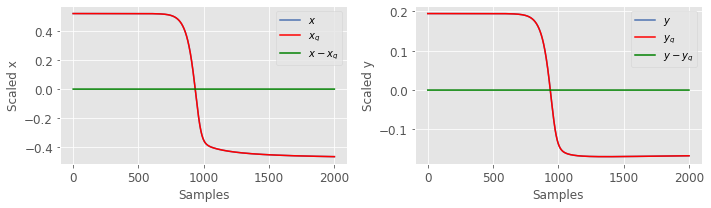

In [75]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs2q[:,0], '-r')
ax1.plot(Es2[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs2q[:,1], '-r')
ax2.plot(Es2[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

In [76]:

U4q = np.zeros((nv,q), dtype=float, order='F')
Z4q = np.zeros((nx,q), dtype=float, order='F')
Xs4q = np.zeros((nx,nv), dtype=float, order='F')

U4q = truncateVecs(nv,q,U4)
Z4q = constructPCData(nx,q,Xs,U4q)
Xs4q = reconstructData(nv,nx,Z4q,U4q)

Es4 = np.absolute(Xs-Xs4q)
print(Es4)

[[6.23945340e-14 5.73152636e-14 2.27595720e-15 ... 1.11022302e-16
  3.93682384e-15 5.55111512e-17]
 [6.25055563e-14 5.74540415e-14 2.30371278e-15 ... 1.66533454e-16
  3.93685965e-15 8.32667268e-17]
 [6.32827124e-14 5.50115509e-14 2.19269047e-15 ... 5.55111512e-17
  3.93689585e-15 5.55111512e-17]
 ...
 [9.82547377e-15 3.33066907e-15 1.24900090e-16 ... 2.77555756e-17
  4.64332005e-14 2.77555756e-17]
 [9.76996262e-15 3.35842465e-15 4.16333634e-17 ... 1.11022302e-16
  4.66415545e-14 5.55111512e-17]
 [9.76996262e-15 3.30291350e-15 1.11022302e-16 ... 5.55111512e-17
  4.68498165e-14 8.32667268e-17]]


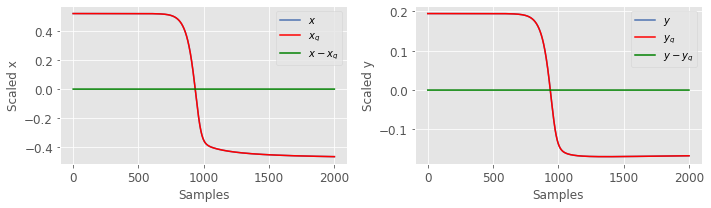

In [77]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs4q[:,0], '-r')
ax1.plot(Es4[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs4q[:,1], '-r')
ax2.plot(Es4[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

In [78]:

U42q = np.zeros((nv,q), dtype=float, order='F')
Z42q = np.zeros((nx,q), dtype=float, order='F')
X42q = np.zeros((nx,nv), dtype=float, order='F')

U42q = truncateVecs(nv,q,U42)
Z42q = constructPCData(nx,q,Xs,U42q)
Xs42q = reconstructData(nv,nx,Z42q,U42q)

Es42 = np.absolute(Xs-Xs42q)
print(Es42)

[[6.70574707e-14 5.70654635e-14 2.16493490e-15 ... 1.11022302e-16
  2.49790994e-14 2.77555756e-17]
 [6.70574707e-14 5.72319969e-14 2.10942375e-15 ... 1.11022302e-16
  2.49791122e-14 2.77555756e-17]
 [6.75015599e-14 5.47062395e-14 2.10942375e-15 ... 5.55111512e-17
  2.49791251e-14 5.55111512e-17]
 ...
 [1.66533454e-15 9.15933995e-16 2.22044605e-16 ... 2.08166817e-16
  5.94721219e-14 5.55111512e-17]
 [1.66533454e-15 8.60422844e-16 2.49800181e-16 ... 2.35922393e-16
  5.96761928e-14 8.32667268e-17]
 [1.77635684e-15 8.60422844e-16 2.08166817e-16 ... 2.08166817e-16
  5.98801537e-14 1.38777878e-16]]


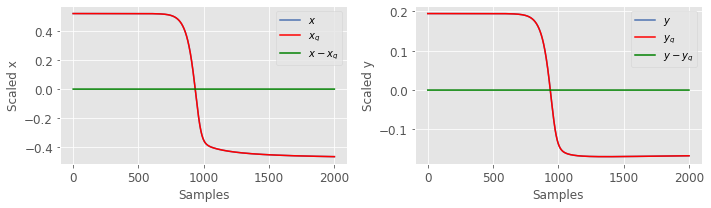

In [79]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs42q[:,0], '-r')
ax1.plot(Es42[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs42q[:,1], '-r')
ax2.plot(Es42[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

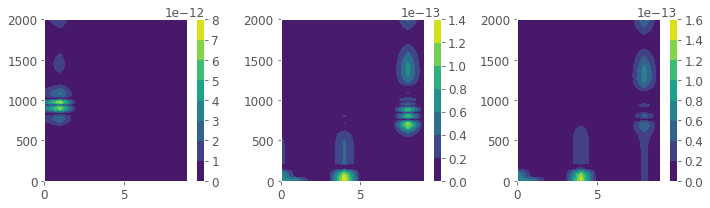

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
f1=ax1.contourf(Es2)
fig.colorbar(f1,ax=ax1)

f2=ax2.contourf(Es4)
fig.colorbar(f2,ax=ax2)

f3=ax3.contourf(Es42)
fig.colorbar(f3,ax=ax3)

In [84]:
Max2 = np.maximum(Es2)
# Max4 = np.max(Es4)
# Max42 = np.max(Es42)

ValueError: invalid number of arguments

In [82]:
print(Max2)
print(Max4)
print(Max42)

7.01234903477399e-12
1.392774784392259e-13
1.4560574967958928e-13


In [83]:
Es2[0].size

10